<a href="https://colab.research.google.com/github/frankuc19/Colab/blob/main/Liberaci%C3%B3n_Automatica_Manual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Correlación de Pearson

In [ ]:
import pandas as pd
import numpy as np
import os

# Definir rutas
csv_path = "/content/drive/MyDrive/Proyectos Tráfico/Modelos de Correlacion/reservas_clientes V1.2.csv"
xlsx_path = "/content/drive/MyDrive/Proyectos Tráfico/Modelos de Correlacion/reservas_clientes V1.2.xlsx"

# Convertir CSV a XLSX si existe
if os.path.exists(csv_path):
    df_csv = pd.read_csv(csv_path)
    df_csv.to_excel(xlsx_path, index=False)
    print("✅ Archivo CSV convertido a XLSX.")

# Cargar datos desde archivo Excel
df = pd.read_excel(xlsx_path)

# 1️⃣ One-Hot Encoding para pickup_geofence_name (6 zonas definidas)
zones = [
    "OTROS", "RESTO DE SANTIAGO", "SANTIAGO ALTA DEMANDA 1",
    "SANTIAGO ALTA DEMANDA 2", "SANTIAGO ALTA DEMANDA 3",
    "SANTIAGO SUR 1", "SANTIAGO SUR 2"
]
df["pickup_geofence_name"] = df["pickup_geofence_name"].apply(lambda x: x if x in zones else "OTROS")
df = pd.get_dummies(df, columns=["pickup_geofence_name"], prefix="zone").astype(int)

# 2️⃣ One-Hot Encoding para diasem (7 categorías, 1 en el día correspondiente)
diasem_dummies = pd.get_dummies(df["dow"], prefix="dow").astype(int)
df = pd.concat([df, diasem_dummies], axis=1).drop(columns=["dow"])

# 3️⃣ One-Hot Encoding para hora (3 categorías: 0-8, 8-17, 17+)
def categorize_hour(hour):
    if 0 <= hour < 8:
        return [1, 0, 0]
    elif 8 <= hour < 17:
        return [0, 1, 0]
    else:
        return [0, 0, 1]

time_encoded = df["hour"].apply(lambda x: pd.Series(categorize_hour(x), index=["hora_madrugada", "hora_dia", "hora_noche"]))
df = pd.concat([df, time_encoded], axis=1).drop(columns=["hour"]).astype(int)

# 6️⃣ One-Hot Encoding para Venta (6 categorías de precios)
def categorize_venta(value):
    if value <= 5000:
        return [1, 0, 0, 0, 0, 0]
    elif value <= 10000:
        return [0, 1, 0, 0, 0, 0]
    elif value <= 15000:
        return [0, 0, 1, 0, 0, 0]
    elif value <= 20000:
        return [0, 0, 0, 1, 0, 0]
    elif value <= 30000:
        return [0, 0, 0, 0, 1, 0]
    else:
        return [0, 0, 0, 0, 0, 1]

venta_encoded = df["payment"].apply(lambda x: pd.Series(categorize_venta(x), index=["venta_1", "venta_2", "venta_3", "venta_4", "venta_5", "venta_6"]))
df = pd.concat([df, venta_encoded], axis=1).drop(columns=["payment"]).astype(int)

# Guardar el dataframe procesado
df.to_csv("/content/drive/MyDrive/Proyectos Tráfico/Modelos de Correlacion/reservas_clientes_procesado.csv", index=False)

# Mostrar las primeras filas del DataFrame procesado
df.head()



✅ Archivo CSV convertido a XLSX.


,trip_id,is_assigned_automatic,is_scheduled,contract,to_airport,is_shared_service,zone_OTROS,zone_RESTO DE SANTIAGO,zone_SANTIAGO ALTA DEMANDA 1,zone_SANTIAGO ALTA DEMANDA 2,...,dow_7,hora_madrugada,hora_dia,hora_noche,venta_1,venta_2,venta_3,venta_4,venta_5,venta_6
0,10064298,1,1,1,0,0,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0
1,1501124,1,1,1,1,1,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
2,1501126,1,1,1,1,1,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0
3,1501124,1,1,1,1,1,0,0,1,0,...,0,1,0,0,0,1,0,0,0,0
4,10004041,1,1,1,1,0,0,0,1,0,...,0,1,0,0,1,0,0,0,0,0


Vista previa de los datos:
    trip_id  is_assigned_automatic  is_scheduled  contract  to_airport  \
0  10064298                      1             1         1           0   
1   1501124                      1             1         1           1   
2   1501126                      1             1         1           1   
3   1501124                      1             1         1           1   
4  10004041                      1             1         1           1   

   is_shared_service  zone_OTROS  zone_RESTO DE SANTIAGO  \
0                  0           1                       0   
1                  1           0                       0   
2                  1           1                       0   
3                  1           0                       0   
4                  0           0                       0   

   zone_SANTIAGO ALTA DEMANDA 1  zone_SANTIAGO ALTA DEMANDA 2  ...  dow_7  \
0                             0                             0  ...      0   
1            

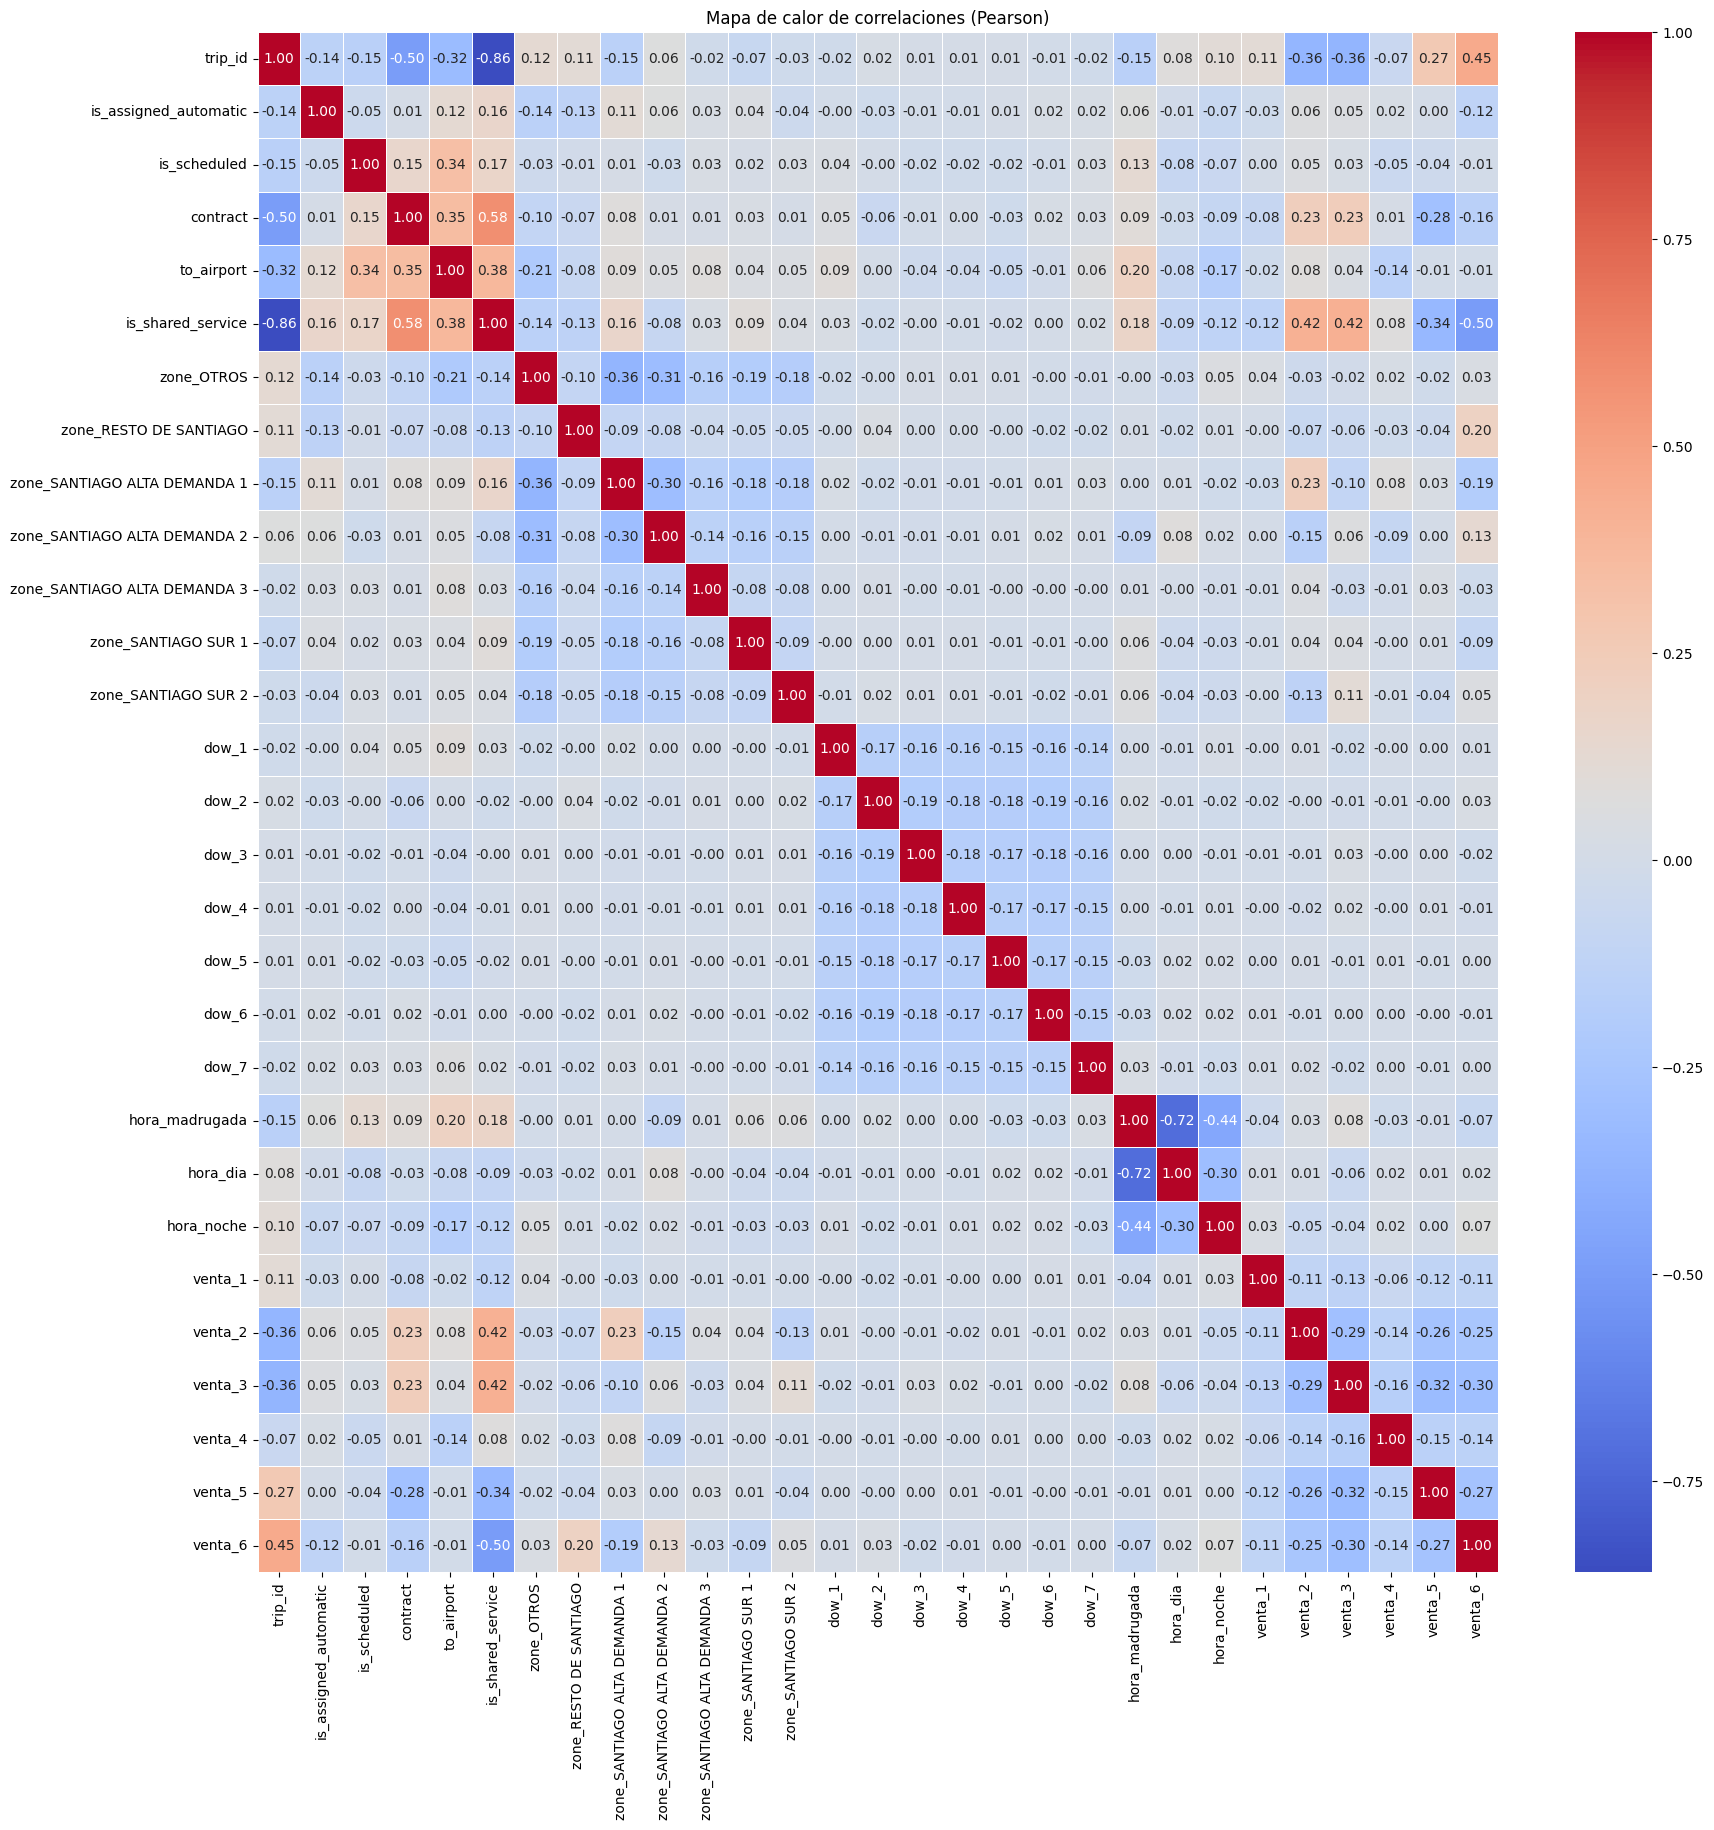

In [ ]:
# ✅ Cargar bibliotecas necesarias
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, kendalltau

# ✅ Especificar la ruta del archivo CSV
ruta_archivo ="/content/drive/MyDrive/Proyectos Tráfico/Modelos de Correlacion/reservas_clientes_procesado.csv"  # 🔄 Reemplaza con la ruta real de tu archivo

# ✅ Cargar los datos en un DataFrame
df = pd.read_csv(ruta_archivo)

# ✅ Mostrar las primeras filas para revisar la estructura
print("Vista previa de los datos:")
print(df.head())

# ✅ Seleccionar solo columnas numéricas para el análisis de correlación
df_numeric = df.select_dtypes(include=['number'])

# ✅ Calcular la matriz de correlación de Pearson
corr_matrix = df_numeric.corr()

# ✅ Filtrar correlaciones relevantes (mayores a 0.5 o menores a -0.5)
corr_filtered = corr_matrix[(corr_matrix > 0.1) | (corr_matrix < -0.2)]
corr_filtered = corr_filtered.unstack().sort_values(ascending=False).dropna()

# ✅ Eliminar duplicados (manteniendo una sola ocurrencia de cada par de variables)
corr_filtered = corr_filtered[corr_filtered < 1].drop_duplicates()

# ✅ Mostrar las correlaciones relevantes
print("Correlaciones relevantes (mayores a 0.1 o menores a -0.5):")
print(corr_filtered)

# ✅ Visualizar la matriz de correlación como un mapa de calor
plt.figure(figsize=(20,20))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Mapa de calor de correlaciones (Pearson)")
plt.show()

Vista previa de los datos:
    trip_id  is_assigned_automatic  is_scheduled  contract  to_airport  \
0  10064298                      1             1         1           0   
1   1501124                      1             1         1           1   
2   1501126                      1             1         1           1   
3   1501124                      1             1         1           1   
4  10004041                      1             1         1           1   

   is_shared_service  zone_OTROS  zone_RESTO DE SANTIAGO  \
0                  0           1                       0   
1                  1           0                       0   
2                  1           1                       0   
3                  1           0                       0   
4                  0           0                       0   

   zone_SANTIAGO ALTA DEMANDA 1  zone_SANTIAGO ALTA DEMANDA 2  ...  dow_7  \
0                             0                             0  ...      0   
1            

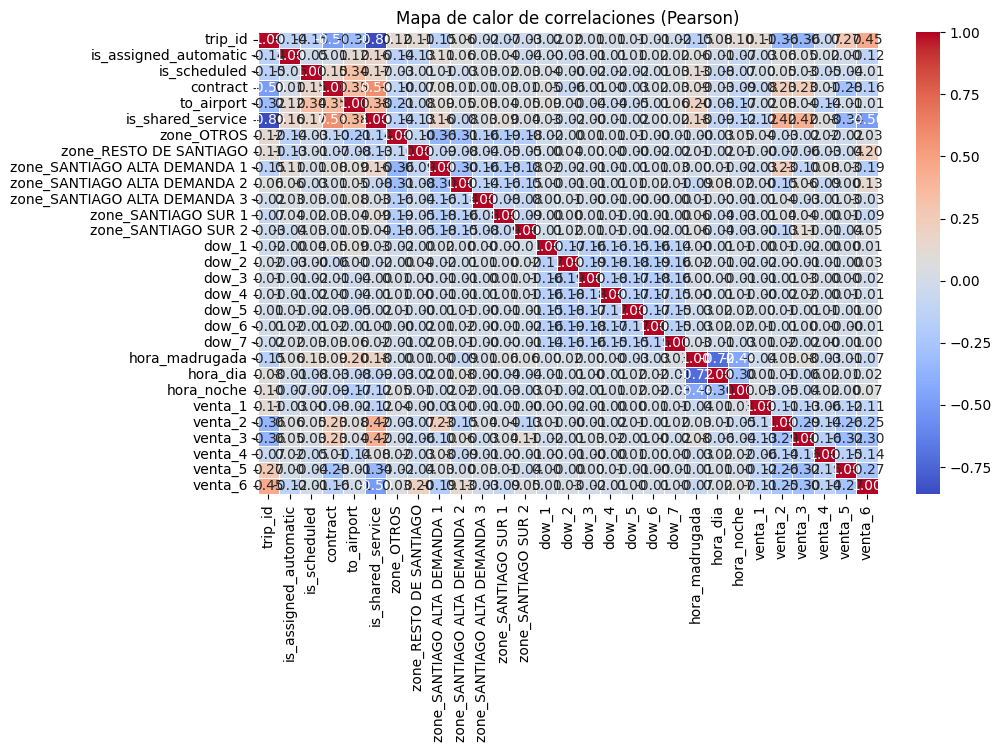


📌 Verificando multicolinealidad con el Factor de Inflación de la Varianza (VIF):



/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


                        Variable       VIF
0                        trip_id  3.853926
1          is_assigned_automatic  1.101596
2                   is_scheduled  1.150507
3                       contract  1.649808
4                     to_airport  1.670035
5              is_shared_service  6.807480
6                     zone_OTROS       inf
7         zone_RESTO DE SANTIAGO       inf
8   zone_SANTIAGO ALTA DEMANDA 1       inf
9   zone_SANTIAGO ALTA DEMANDA 2       inf
10  zone_SANTIAGO ALTA DEMANDA 3       inf
11           zone_SANTIAGO SUR 1       inf
12           zone_SANTIAGO SUR 2       inf
13                         dow_1       inf
14                         dow_2       inf
15                         dow_3       inf
16                         dow_4       inf
17                         dow_5       inf
18                         dow_6       inf
19                         dow_7       inf
20                hora_madrugada       inf
21                      hora_dia       inf
22         

In [ ]:
# ✅ Cargar bibliotecas necesarias
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor

# ✅ Especificar la ruta del archivo CSV
ruta_archivo = "/content/drive/MyDrive/Proyectos Tráfico/Modelos de Correlacion/reservas_clientes_procesado.csv"  # 🔄 Reemplaza con la ruta real de tu archivo

# ✅ Cargar los datos en un DataFrame
df = pd.read_csv(ruta_archivo)

# ✅ Mostrar las primeras filas para revisar la estructura
print("Vista previa de los datos:")
print(df.head())

# ✅ Seleccionar solo columnas numéricas para el análisis de correlación
df_numeric = df.select_dtypes(include=['number'])

# ✅ Calcular la matriz de correlación de Pearson
corr_matrix = df_numeric.corr()

# ✅ Filtrar correlaciones relevantes (mayores a 0.1 o menores a -0.5)
corr_filtered = corr_matrix[(corr_matrix > 0.1)] #| (corr_matrix < -0.5)]
corr_filtered = corr_filtered.unstack().sort_values(ascending=False).dropna()

# ✅ Eliminar duplicados (manteniendo una sola ocurrencia de cada par de variables)
corr_filtered = corr_filtered[corr_filtered < 1].drop_duplicates()

# ✅ Mostrar las correlaciones relevantes
print("Correlaciones relevantes (mayores a 0.1 o menores a -0.5):")
print(corr_filtered)

# ✅ Visualizar la matriz de correlación como un mapa de calor
plt.figure(figsize=(10,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Mapa de calor de correlaciones (Pearson)")
plt.show()

# ✅ Calcular el Factor de Inflación de la Varianza (VIF) para verificar multicolinealidad
print("\n📌 Verificando multicolinealidad con el Factor de Inflación de la Varianza (VIF):\n")

X = df_numeric.dropna()  # Eliminar valores nulos antes del cálculo
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# ✅ Mostrar los valores de VIF
print(vif_data)


Vista previa de los datos:
    trip_id  is_assigned_automatic  is_scheduled  contract  to_airport  \
0  10064298                      1             1         1           0   
1   1501124                      1             1         1           1   
2   1501126                      1             1         1           1   
3   1501124                      1             1         1           1   
4  10004041                      1             1         1           1   

   is_shared_service  zone_OTROS  zone_RESTO DE SANTIAGO  \
0                  0           1                       0   
1                  1           0                       0   
2                  1           1                       0   
3                  1           0                       0   
4                  0           0                       0   

   zone_SANTIAGO ALTA DEMANDA 1  zone_SANTIAGO ALTA DEMANDA 2  ...  dow_7  \
0                             0                             0  ...      0   
1            

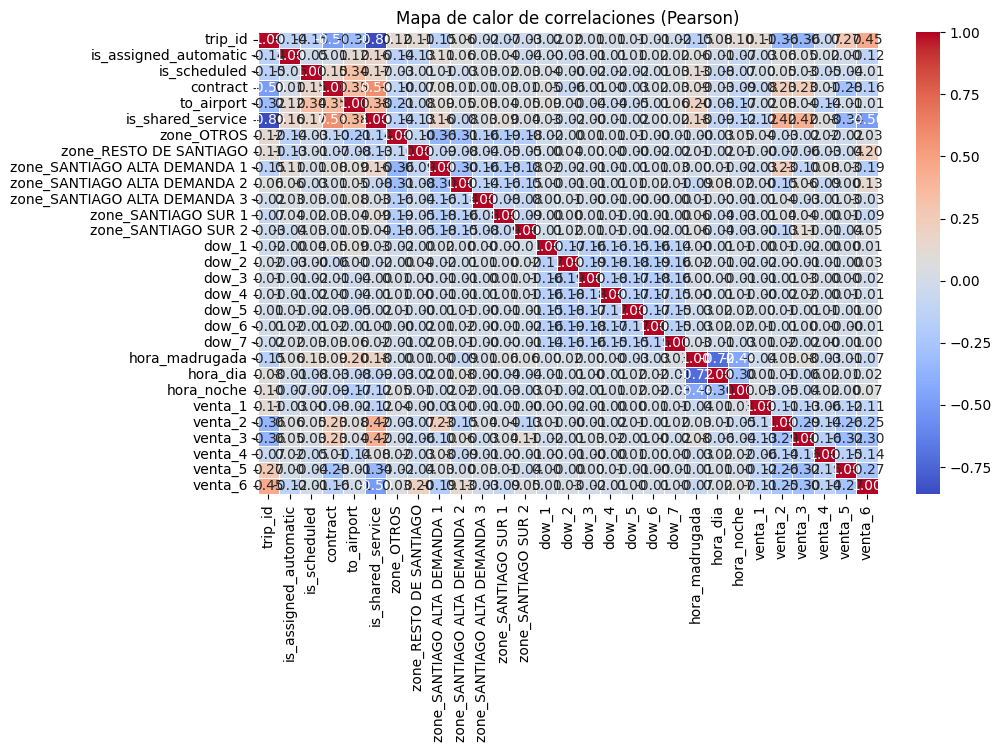


📌 Verificando multicolinealidad con el Factor de Inflación de la Varianza (VIF):



/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


                        Variable       VIF
0                        trip_id  3.853926
1          is_assigned_automatic  1.101596
2                   is_scheduled  1.150507
3                       contract  1.649808
4                     to_airport  1.670035
5              is_shared_service  6.807480
6                     zone_OTROS       inf
7         zone_RESTO DE SANTIAGO       inf
8   zone_SANTIAGO ALTA DEMANDA 1       inf
9   zone_SANTIAGO ALTA DEMANDA 2       inf
10  zone_SANTIAGO ALTA DEMANDA 3       inf
11           zone_SANTIAGO SUR 1       inf
12           zone_SANTIAGO SUR 2       inf
13                         dow_1       inf
14                         dow_2       inf
15                         dow_3       inf
16                         dow_4       inf
17                         dow_5       inf
18                         dow_6       inf
19                         dow_7       inf
20                hora_madrugada       inf
21                      hora_dia       inf
22         

In [ ]:
# ✅ Cargar bibliotecas necesarias
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr, spearmanr, kendalltau, ttest_ind
from statsmodels.stats.outliers_influence import variance_inflation_factor

# ✅ Especificar la ruta del archivo CSV
ruta_archivo = "/content/drive/MyDrive/Proyectos Tráfico/Modelos de Correlacion/reservas_clientes_procesado.csv"  # 🔄 Reemplaza con la ruta real de tu archivo

# ✅ Cargar los datos en un DataFrame
df = pd.read_csv(ruta_archivo)

# ✅ Mostrar las primeras filas para revisar la estructura
print("Vista previa de los datos:")
print(df.head())

# ✅ Seleccionar solo columnas numéricas para el análisis de correlación
df_numeric = df.select_dtypes(include=['number'])

# ✅ Calcular la matriz de correlación de Pearson
corr_matrix = df_numeric.corr()

# ✅ Filtrar correlaciones relevantes (mayores a 0.1)
corr_filtered = corr_matrix[(corr_matrix > 0.1)] #| (corr_matrix < -0.5)]
corr_filtered = corr_filtered.unstack().sort_values(ascending=False).dropna()

# ✅ Eliminar duplicados (manteniendo una sola ocurrencia de cada par de variables)
corr_filtered = corr_filtered[corr_filtered < 1].drop_duplicates()

# ✅ Mostrar las correlaciones relevantes
print("\n📌 Correlaciones relevantes (mayores a 0.1):")
print(corr_filtered)

# ✅ Visualizar la matriz de correlación como un mapa de calor
plt.figure(figsize=(10,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Mapa de calor de correlaciones (Pearson)")
plt.show()

# ✅ Calcular el Factor de Inflación de la Varianza (VIF) para verificar multicolinealidad
print("\n📌 Verificando multicolinealidad con el Factor de Inflación de la Varianza (VIF):\n")

X = df_numeric.dropna()  # Eliminar valores nulos antes del cálculo
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# ✅ Mostrar los valores de VIF
print(vif_data)

# ✅ Realizar pruebas de hipótesis (Test de Pearson) para evaluar la significancia de la correlación
print("\n📌 Pruebas de hipótesis para la significancia de la correlación:\n")

significance_results = []
alpha = 0.05  # Nivel de significancia

for (var1, var2), corr_value in corr_filtered.items():
    pearson_corr, p_value = pearsonr(df_numeric[var1], df_numeric[var2])

    # Determinar si la correlación es estadísticamente significativa
    significant = "Sí" if p_value < alpha else "No"

    # Guardar resultados en una lista
    significance_results.append((var1, var2, corr_value, pearson_corr, p_value, significant))

# ✅ Convertir resultados en un DataFrame ordenado
df_significance = pd.DataFrame(significance_results, columns=["Variable 1", "Variable 2", "Corr. Pearson", "Pearson Coef", "p-Valor", "Significativa?"])
df_significance = df_significance.sort_values(by="p-Valor")

# ✅ Mostrar la tabla de resultados de significancia
print(df_significance)



In [ ]:
import pandas as pd
import numpy as np

# Cargar datos (ajustar ruta según Colab)
file_path = "/content/drive/MyDrive/Proyectos Tráfico/Modelos de Correlacion/reservas_clientes V1.2.xlsx"
df = pd.read_excel(file_path)

# 1️⃣ One-Hot Encoding para pickup_geofence_name (6 zonas definidas)
zones = [
    "OTROS", "RESTO DE SANTIAGO", "SANTIAGO ALTA DEMANDA 1",
    "SANTIAGO ALTA DEMANDA 2", "SANTIAGO ALTA DEMANDA 3",
    "SANTIAGO SUR 1", "SANTIAGO SUR 2"
]
df["pickup_geofence_name"] = df["pickup_geofence_name"].apply(lambda x: x if x in zones else "OTROS")
df = pd.get_dummies(df, columns=["pickup_geofence_name"], prefix="zone").astype(int)

# 2️⃣ One-Hot Encoding para diasem (7 categorías, 1 en el día correspondiente)
diasem_dummies = pd.get_dummies(df["dow"], prefix="dow").astype(int)
df = pd.concat([df, diasem_dummies], axis=1).drop(columns=["dow"])

# 3️⃣ One-Hot Encoding para hora (3 categorías: 0-8, 8-17, 17+)
def categorize_hour(hour):
    if 0 <= hour < 8:
        return [1, 0, 0]
    elif 8 <= hour < 17:
        return [0, 1, 0]
    else:
        return [0, 0, 1]

time_encoded = df["hour"].apply(lambda x: pd.Series(categorize_hour(x), index=["hora_madrugada", "hora_dia", "hora_noche"]))
df = pd.concat([df, time_encoded], axis=1).drop(columns=["hour"]).astype(int)

# 6️⃣ One-Hot Encoding para Venta (6 categorías de precios)
def categorize_venta(value):
    if value <= 5000:
        return [1, 0, 0, 0, 0, 0]
    elif value <= 10000:
        return [0, 1, 0, 0, 0, 0]
    elif value <= 15000:
        return [0, 0, 1, 0, 0, 0]
    elif value <= 20000:
        return [0, 0, 0, 1, 0, 0]
    elif value <= 30000:
        return [0, 0, 0, 0, 1, 0]
    else:
        return [0, 0, 0, 0, 0, 1]

venta_encoded = df["payment"].apply(lambda x: pd.Series(categorize_venta(x), index=["venta_1", "venta_2", "venta_3", "venta_4", "venta_5", "venta_6"]))
df = pd.concat([df, venta_encoded], axis=1).drop(columns=["payment"]).astype(int)


# Definir la variable objetivo (Y)
Y = df["is_assigned_automatic"]

# Calcular la matriz de correlación con la variable Y
correlation_matrix = df.corr()
correlation_with_Y = correlation_matrix["is_assigned_automatic"].sort_values(ascending=False)
print("Correlación de las variables con Y (is_assigned_automatic):\n", correlation_with_Y)

# Guardar el dataframe procesado
df.to_csv("/content/drive/MyDrive/Proyectos Tráfico/Modelos de Correlacion/reservas_clientes_procesado.csv", index=False)

# Mostrar las primeras filas del DataFrame procesado
df.head()


Correlación de las variables con Y (is_assigned_automatic):
 is_assigned_automatic           1.000000
is_shared_service               0.163804
to_airport                      0.121534
zone_SANTIAGO ALTA DEMANDA 1    0.113716
hora_madrugada                  0.063792
zone_SANTIAGO ALTA DEMANDA 2    0.062976
venta_2                         0.062823
venta_3                         0.052044
zone_SANTIAGO SUR 1             0.043664
zone_SANTIAGO ALTA DEMANDA 3    0.033311
dow_7                           0.022065
venta_4                         0.021889
dow_6                           0.020685
contract                        0.011872
dow_5                           0.010054
venta_5                         0.004169
dow_1                          -0.003798
dow_3                          -0.005406
dow_4                          -0.009358
hora_dia                       -0.010708
venta_1                        -0.029543
dow_2                          -0.030923
zone_SANTIAGO SUR 2            -0.044

,trip_id,is_assigned_automatic,is_scheduled,contract,to_airport,is_shared_service,zone_OTROS,zone_RESTO DE SANTIAGO,zone_SANTIAGO ALTA DEMANDA 1,zone_SANTIAGO ALTA DEMANDA 2,...,dow_7,hora_madrugada,hora_dia,hora_noche,venta_1,venta_2,venta_3,venta_4,venta_5,venta_6
0,10064298,1,1,1,0,0,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0
1,1501124,1,1,1,1,1,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
2,1501126,1,1,1,1,1,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0
3,1501124,1,1,1,1,1,0,0,1,0,...,0,1,0,0,0,1,0,0,0,0
4,10004041,1,1,1,1,0,0,0,1,0,...,0,1,0,0,1,0,0,0,0,0


# Regresión Logística

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import joblib

# Cargar datos
file_path = "/content/drive/MyDrive/Proyectos Tráfico/Modelos de Correlacion/reservas_clientes V1.2.xlsx"
df = pd.read_excel(file_path)

# 1️⃣ One-Hot Encoding para pickup_geofence_name
zones = [
    "OTROS", "RESTO DE SANTIAGO", "SANTIAGO ALTA DEMANDA 1",
    "SANTIAGO ALTA DEMANDA 2", "SANTIAGO ALTA DEMANDA 3",
    "SANTIAGO SUR 1", "SANTIAGO SUR 2"
]
df["pickup_geofence_name"] = df["pickup_geofence_name"].apply(lambda x: x if x in zones else "OTROS")
df = pd.get_dummies(df, columns=["pickup_geofence_name"], prefix="zone").astype(int)

# 2️⃣ One-Hot Encoding para hora
def categorize_hour(hour):
    if 0 <= hour < 8:
        return [1, 0, 0]
    elif 8 <= hour < 17:
        return [0, 1, 0]
    else:
        return [0, 0, 1]

time_encoded = df["hour"].apply(lambda x: pd.Series(categorize_hour(x), index=["hora_madrugada", "hora_dia", "hora_noche"]))
df = pd.concat([df, time_encoded], axis=1).drop(columns=["hour"]).astype(int)

# 3️⃣ One-Hot Encoding para Venta
def categorize_venta(value):
    if value <= 5000:
        return [1, 0, 0, 0, 0, 0]
    elif value <= 10000:
        return [0, 1, 0, 0, 0, 0]
    elif value <= 15000:
        return [0, 0, 1, 0, 0, 0]
    elif value <= 20000:
        return [0, 0, 0, 1, 0, 0]
    elif value <= 30000:
        return [0, 0, 0, 0, 1, 0]
    else:
        return [0, 0, 0, 0, 0, 1]

venta_encoded = df["payment"].apply(lambda x: pd.Series(categorize_venta(x), index=["venta_1", "venta_2", "venta_3", "venta_4", "venta_5", "venta_6"]))
df = pd.concat([df, venta_encoded], axis=1).drop(columns=["payment"]).astype(int)

# Variables a usar según la correlación
features = [
    "is_shared_service", "to_airport",
    "zone_SANTIAGO ALTA DEMANDA 1", "zone_SANTIAGO ALTA DEMANDA 2",
    "hora_madrugada", "hora_noche",
    "venta_2", "venta_6",
    "zone_OTROS", "zone_RESTO DE SANTIAGO",
   ## "trip_id"  # Puedes comentar esta línea si no aporta valor real
]

# Definir X e Y
Y = df["is_assigned_automatic"]
X = df[features]

# Dividir los datos
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# SMOTE para balancear clases
smote = SMOTE(random_state=42)
X_train_resampled, Y_train_resampled = smote.fit_resample(X_train, Y_train)

# Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Modelo de regresión logística
class_weights = {0: 3, 1: 1}
model = LogisticRegression(class_weight=class_weights)
model.fit(X_train_scaled, Y_train_resampled)

# Predicciones
Y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
threshold = 0.20
Y_pred_adjusted = (Y_pred_proba >= threshold).astype(int)

# Evaluación
accuracy = accuracy_score(Y_test, Y_pred_adjusted)
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(Y_test, Y_pred_adjusted))
print("\nConfusion Matrix:\n", confusion_matrix(Y_test, Y_pred_adjusted))

# Guardar el modelo
joblib.dump(model, "/content/drive/MyDrive/Proyectos Tráfico/Modelos de Correlacion/modelo_regresion_logistica.pkl")


Accuracy: 0.7352443133215788

Classification Report:
               precision    recall  f1-score   support

           0       0.34      0.44      0.38     10790
           1       0.86      0.80      0.83     46493

    accuracy                           0.74     57283
   macro avg       0.60      0.62      0.61     57283
weighted avg       0.76      0.74      0.75     57283


Confusion Matrix:
 [[ 4747  6043]
 [ 9123 37370]]


['/content/drive/MyDrive/Proyectos Tráfico/Modelos de Correlacion/modelo_regresion_logistica.pkl']

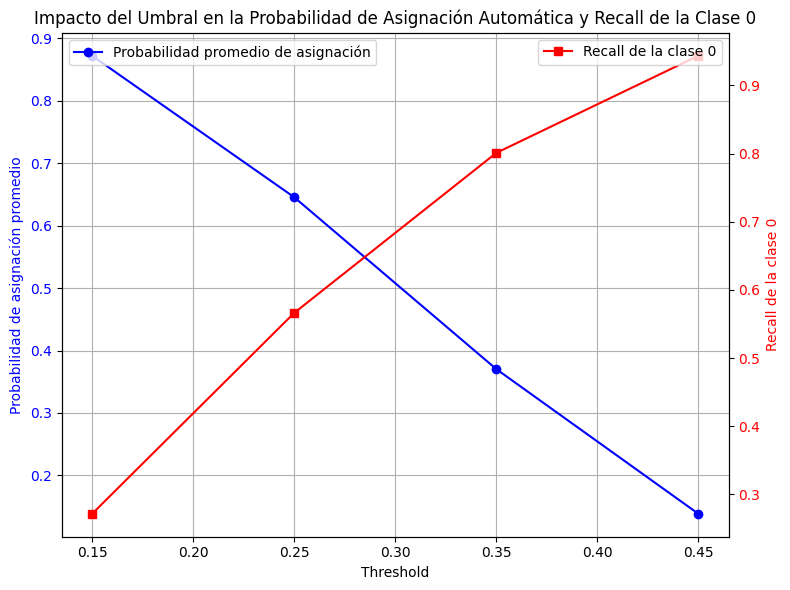

In [ ]:
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt
import numpy as np

# Evaluar diferentes umbrales
thresholds = np.arange(0.15, 0.55, 0.1)
preds = []
recalls = []

for threshold in thresholds:
    Y_pred_adjusted = (Y_pred_proba >= threshold).astype(int)
    preds.append(Y_pred_adjusted.mean())  # Probabilidad de asignación promedio
    recall_0 = recall_score(Y_test, Y_pred_adjusted, pos_label=0)  # Recall de la clase 0
    recalls.append(recall_0)

# Graficar la relación entre umbral y probabilidad de asignación
fig, ax1 = plt.subplots(figsize=(8, 6))

# Eje izquierdo para la probabilidad de asignación promedio
ax1.plot(thresholds, preds, marker='o', linestyle='-', color='b', label="Probabilidad promedio de asignación")
ax1.set_xlabel("Threshold")
ax1.set_ylabel("Probabilidad de asignación promedio", color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Eje derecho para el recall de la clase 0
ax2 = ax1.twinx()  # Crear un eje Y secundario
ax2.plot(thresholds, recalls, marker='s', linestyle='-', color='r', label="Recall de la clase 0")
ax2.set_ylabel("Recall de la clase 0", color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Títulos y leyenda
ax1.set_title("Impacto del Umbral en la Probabilidad de Asignación Automática y Recall de la Clase 0")
fig.tight_layout()  # Ajustar el diseño para que no se sobrepongan los textos
ax1.grid(True)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

# Ajustar el umbral de decisión
threshold = 0.15  # Se baja aún más el umbral para mejorar el recall de la clase 0
Y_pred_adjusted = (Y_pred_proba >= threshold).astype(int)


# Predicción del módelo (Regresión Logística)

In [ ]:
import joblib

# Crear y entrenar el scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)  # Ajusta el scaler en los datos de entrenamiento

# Guardar el scaler para usarlo después
joblib.dump(scaler, "/content/drive/MyDrive/Proyectos Tráfico/Modelos de Correlacion/scaler.pkl")


['/content/drive/MyDrive/Proyectos Tráfico/Modelos de Correlacion/scaler.pkl']

In [ ]:
import pandas as pd
import numpy as np
import joblib

# Cargar el modelo y el escalador
model = joblib.load("/content/drive/MyDrive/Proyectos Tráfico/Modelos de Correlacion/modelo_regresion_logistica.pkl")
scaler = joblib.load("/content/drive/MyDrive/Proyectos Tráfico/Modelos de Correlacion/scaler.pkl")

# Cargar columnas del entrenamiento
columnas_entrenamiento = joblib.load("/content/drive/MyDrive/Proyectos Tráfico/Modelos de Correlacion/columnas_entrenamiento.pkl")

# Leer datos nuevos desde Google Sheets
sheet_id = "1ZLwfPqKG2LP2eqp7hDkFeUCSw2jsgGhkmek3xL2KzGc"
sheet_name = "Regre.Log"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
df_nuevo = pd.read_csv(url)

# Normalizar zonas
zones = [
    "OTROS", "RESTO DE SANTIAGO", "SANTIAGO ALTA DEMANDA 1",
    "SANTIAGO ALTA DEMANDA 2", "SANTIAGO ALTA DEMANDA 3",
    "SANTIAGO SUR 1", "SANTIAGO SUR 2"
]
df_nuevo["pickup_geofence_name"] = df_nuevo["pickup_geofence_name"].apply(lambda x: x if x in zones else "OTROS")

# Codificar zonas
df_nuevo = pd.get_dummies(df_nuevo, columns=["pickup_geofence_name"], prefix="zone")
df_nuevo = df_nuevo.fillna(0).astype(int)

# Codificar día de la semana
diasem_dummies = pd.get_dummies(df_nuevo["dow"], prefix="dow")
diasem_dummies = diasem_dummies.fillna(0).astype(int)
df_nuevo = pd.concat([df_nuevo, diasem_dummies], axis=1).drop(columns=["dow"])

# One-Hot Encoding para hora
def categorize_hour(hour):
    if pd.isnull(hour):
        return [0, 0, 0]
    if 0 <= hour < 8:
        return [1, 0, 0]
    elif 8 <= hour < 17:
        return [0, 1, 0]
    else:
        return [0, 0, 1]

time_encoded = df_nuevo["hour"].apply(lambda x: pd.Series(categorize_hour(x), index=["hora_madrugada", "hora_dia", "hora_noche"]))
df_nuevo = pd.concat([df_nuevo.drop(columns=["hour"]), time_encoded], axis=1).astype(int)

# One-Hot Encoding para venta
def categorize_venta(value):
    if pd.isnull(value):
        return [0, 0, 0, 0, 0, 0]
    if value <= 5000:
        return [1, 0, 0, 0, 0, 0]
    elif value <= 10000:
        return [0, 1, 0, 0, 0, 0]
    elif value <= 15000:
        return [0, 0, 1, 0, 0, 0]
    elif value <= 20000:
        return [0, 0, 0, 1, 0, 0]
    elif value <= 30000:
        return [0, 0, 0, 0, 1, 0]
    else:
        return [0, 0, 0, 0, 0, 1]

venta_encoded = df_nuevo["payment"].apply(lambda x: pd.Series(categorize_venta(x), index=["venta_1", "venta_2", "venta_3", "venta_4", "venta_5", "venta_6"]))
df_nuevo = pd.concat([df_nuevo.drop(columns=["payment"]), venta_encoded], axis=1).astype(int)

# Asegurar que el DataFrame tenga exactamente las columnas del entrenamiento
# Agregar columnas faltantes
for col in columnas_entrenamiento:
    if col not in df_nuevo.columns:
        df_nuevo[col] = 0

# Eliminar columnas sobrantes
df_nuevo = df_nuevo[columnas_entrenamiento]

# Escalar los datos
X_nuevo_scaled = scaler.transform(df_nuevo)

# Predicción
Y_pred_proba_nuevo = model.predict_proba(X_nuevo_scaled)[:, 1]
threshold = 0.30
df_nuevo["Prediccion_asignacion"] = (Y_pred_proba_nuevo >= threshold).astype(int)
df_nuevo["Probabilidad_asignacion_%"] = (Y_pred_proba_nuevo * 100).round(2)

# Mover columnas al final
columnas_resultado = ["Probabilidad_asignacion_%", "Prediccion_asignacion"]
otras_columnas = [col for col in df_nuevo.columns if col not in columnas_resultado]
df_nuevo = df_nuevo[otras_columnas + columnas_resultado]

# Guardar resultados
df_nuevo.to_excel("/content/drive/MyDrive/Proyectos Tráfico/Modelos de Correlacion/predicciones_reservas.xlsx", index=False)

print("✅ Predicciones guardadas en 'predicciones_reservas.xlsx'.")



ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- contract
- dow_1
- dow_2
- dow_3
- dow_4
- ...


In [ ]:
import pandas as pd
import numpy as np
import joblib

# Cargar el modelo y el escalador
model = joblib.load("/content/drive/MyDrive/Proyectos Tráfico/Modelos de Correlacion/modelo_regresion_logistica.pkl")
scaler = joblib.load("/content/drive/MyDrive/Proyectos Tráfico/Modelos de Correlacion/scaler.pkl")

# Guardar las columnas del entrenamiento
joblib.dump(X.columns.tolist(), "/content/drive/MyDrive/Proyectos Tráfico/Modelos de Correlacion/columnas_entrenamiento.pkl")

# ID y nombre de la hoja
sheet_id = "1ZLwfPqKG2LP2eqp7hDkFeUCSw2jsgGhkmek3xL2KzGc"
sheet_name = "Regre.Log"

# URL de exportación a CSV
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"

# Leer directamente la hoja como DataFrame
df_nuevo = pd.read_csv(url)

# Cargar nueva base de datos
#file_path_nueva = "/content/drive/MyDrive/Proyectos Tráfico/Modelos de Correlacion/El Data.gsheet"
#df_nuevo = pd.read_excel(file_path_nueva)

# Normalizar zonas
zones = [
    "OTROS", "RESTO DE SANTIAGO", "SANTIAGO ALTA DEMANDA 1",
    "SANTIAGO ALTA DEMANDA 2", "SANTIAGO ALTA DEMANDA 3",
    "SANTIAGO SUR 1", "SANTIAGO SUR 2"
]
df_nuevo["pickup_geofence_name"] = df_nuevo["pickup_geofence_name"].apply(lambda x: x if x in zones else "OTROS")

# Codificar zonas
df_nuevo = pd.get_dummies(df_nuevo, columns=["pickup_geofence_name"], prefix="zone")
df_nuevo = df_nuevo.fillna(0).astype(int)

# Codificar día de la semana
diasem_dummies = pd.get_dummies(df_nuevo["dow"], prefix="dow")
diasem_dummies = diasem_dummies.fillna(0).astype(int)
df_nuevo = pd.concat([df_nuevo, diasem_dummies], axis=1).drop(columns=["dow"])

# One-Hot Encoding para hora (3 categorías: 0-8, 8-17, 17+)
def categorize_hour(hour):
    if pd.isnull(hour):
        return [0, 0, 0]
    if 0 <= hour < 8:
        return [1, 0, 0]
    elif 8 <= hour < 17:
        return [0, 1, 0]
    else:
        return [0, 0, 1]

time_encoded = df_nuevo["hour"].apply(lambda x: pd.Series(categorize_hour(x), index=["hora_madrugada", "hora_dia", "hora_noche"]))
df_nuevo = pd.concat([df_nuevo.drop(columns=["hour"]), time_encoded], axis=1).astype(int)

# One-Hot Encoding para Venta (6 categorías de precios)
def categorize_venta(value):
    if pd.isnull(value):
        return [0, 0, 0, 0, 0, 0]
    if value <= 5000:
        return [1, 0, 0, 0, 0, 0]
    elif value <= 10000:
        return [0, 1, 0, 0, 0, 0]
    elif value <= 15000:
        return [0, 0, 1, 0, 0, 0]
    elif value <= 20000:
        return [0, 0, 0, 1, 0, 0]
    elif value <= 30000:
        return [0, 0, 0, 0, 1, 0]
    else:
        return [0, 0, 0, 0, 0, 1]

venta_encoded = df_nuevo["payment"].apply(lambda x: pd.Series(categorize_venta(x), index=["venta_1", "venta_2", "venta_3", "venta_4", "venta_5", "venta_6"]))
df_nuevo = pd.concat([df_nuevo.drop(columns=["payment"]), venta_encoded], axis=1).astype(int)


# Asegurar que las columnas sean las mismas que en el entrenamiento
columnas_entrenamiento = joblib.load("/content/drive/MyDrive/Proyectos Tráfico/Modelos de Correlacion/columnas_entrenamiento.pkl")
for col in columnas_entrenamiento:
    if col not in df_nuevo:
        df_nuevo[col] = 0

# Ordenar columnas
df_nuevo = df_nuevo[columnas_entrenamiento]

# Asegurar que no hay NaNs antes de escalar
df_nuevo = df_nuevo.fillna(0)

# Escalar los datos
X_nuevo_scaled = scaler.transform(df_nuevo)

# Predicciones
Y_pred_proba_nuevo = model.predict_proba(X_nuevo_scaled)[:, 1]

threshold = 0.30  # Umbral de asignación
df_nuevo["Prediccion_asignacion"] = (Y_pred_proba_nuevo >= threshold).astype(int)

# Agregar columna con % de probabilidad
df_nuevo["Probabilidad_asignacion_%"] = (Y_pred_proba_nuevo * 100).round(2)

# Mover columnas de resultado al final
columnas_resultado = ["Probabilidad_asignacion_%", "Prediccion_asignacion"]
otras_columnas = [col for col in df_nuevo.columns if col not in columnas_resultado]
df_nuevo = df_nuevo[otras_columnas + columnas_resultado]


# Guardar resultados
df_nuevo.to_excel("/content/drive/MyDrive/Proyectos Tráfico/Modelos de Correlacion/predicciones_reservas.xlsx", index=False)

print("Predicciones guardadas en 'predicciones_reservas.xlsx'.")

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- contract
- dow_1
- dow_2
- dow_3
- dow_4
- ...


# Predicción del módelo Redes Neuronales

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import joblib

# Cargar datos
file_path = "/content/drive/MyDrive/Proyectos Tráfico/Modelos de Correlacion/reservas_clientes V1.2.xlsx"
df = pd.read_excel(file_path)


# 1️⃣ One-Hot Encoding para zonas de pickup
zones = [
    "OTROS", "RESTO DE SANTIAGO", "SANTIAGO ALTA DEMANDA 1",
    "SANTIAGO ALTA DEMANDA 2", "SANTIAGO ALTA DEMANDA 3",
    "SANTIAGO SUR 1", "SANTIAGO SUR 2"
]
df["pickup_geofence_name"] = df["pickup_geofence_name"].apply(lambda x: x if x in zones else "OTROS")
df = pd.get_dummies(df, columns=["pickup_geofence_name"], prefix="zone").astype(int)

# 2️⃣ One-Hot Encoding para día de la semana
diasem_dummies = pd.get_dummies(df["dow"], prefix="dow").astype(int)
df = pd.concat([df, diasem_dummies], axis=1).drop(columns=["dow"])

# 3️⃣ One-Hot Encoding para la hora
def categorize_hour(hour):
    if 0 <= hour < 8:
        return [1, 0, 0]
    elif 8 <= hour < 17:
        return [0, 1, 0]
    else:
        return [0, 0, 1]

time_encoded = df["hour"].apply(lambda x: pd.Series(categorize_hour(x), index=["hora_madrugada", "hora_dia", "hora_noche"]))
df = pd.concat([df, time_encoded], axis=1).drop(columns=["hour"]).astype(int)

# 4️⃣ One-Hot Encoding para el monto de pago
def categorize_venta(value):
    if pd.isnull(value):
        return [0, 0, 0, 0, 0, 0]
    if value <= 5000:
        return [1, 0, 0, 0, 0, 0]
    elif value <= 10000:
        return [0, 1, 0, 0, 0, 0]
    elif value <= 15000:
        return [0, 0, 1, 0, 0, 0]
    elif value <= 20000:
        return [0, 0, 0, 1, 0, 0]
    elif value <= 30000:
        return [0, 0, 0, 0, 1, 0]
    else:
        return [0, 0, 0, 0, 0, 1]

venta_encoded = df["payment"].apply(lambda x: pd.Series(categorize_venta(x), index=["venta_1", "venta_2", "venta_3", "venta_4", "venta_5", "venta_6"]))
df = pd.concat([df, venta_encoded], axis=1).drop(columns=["payment"]).astype(int)

# Definir la variable objetivo (Y) y las variables predictoras (X)
Y = df["is_assigned_automatic"]
X = df.drop(columns=["is_assigned_automatic"])

# Guardar las columnas del entrenamiento
joblib.dump(X.columns.tolist(), "columnas_entrenamiento.pkl")

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Aplicar SMOTE para balancear clases
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, Y_train_resampled = smote.fit_resample(X_train, Y_train)

# Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Guardar el scaler
joblib.dump(scaler, "scaler.pkl")

# 📌 1️⃣ Crear el modelo MLP (Red Neuronal)
model = Sequential([
    Dense(64, activation="relu", input_shape=(X_train_scaled.shape[1],)),  # Capa de entrada
    Dropout(0.3),  # Evitar overfitting
    Dense(32, activation="relu"),
    Dropout(0.3),
    Dense(16, activation="relu"),
    Dense(1, activation="sigmoid")  # Capa de salida binaria
])

# 📌 2️⃣ Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=["accuracy"])

# 📌 3️⃣ Entrenar el modelo (5 epocas)
history = model.fit(X_train_scaled, Y_train_resampled, epochs=5, batch_size=32, validation_data=(X_test_scaled, Y_test), verbose=1)

# 📌 4️⃣ Evaluar el modelo
Y_pred_proba = model.predict(X_test_scaled).flatten()
threshold = 0.30  # Ajustar umbral
Y_pred_adjusted = (Y_pred_proba >= threshold).astype(int)

accuracy = accuracy_score(Y_test, Y_pred_adjusted)
print("\nAccuracy:", accuracy)
print("\nClassification Report:\n", classification_report(Y_test, Y_pred_adjusted))
print("\nConfusion Matrix:\n", confusion_matrix(Y_test, Y_pred_adjusted))

# 📌 5️⃣ Guardar el modelo
model.save("modelo_mlp.h5")
print("\nModelo MLP guardado como 'modelo_mlp.h5'")


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11642/11642 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - accuracy: 0.8312 - loss: 0.3655 - val_accuracy: 0.8171 - val_loss: 0.4456
Epoch 2/5
11642/11642 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - accuracy: 0.8587 - loss: 0.3184 - val_accuracy: 0.8179 - val_loss: 0.4577
Epoch 3/5
11642/11642 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - accuracy: 0.8589 - loss: 0.3175 - val_accuracy: 0.8172 - val_loss: 0.4501
Epoch 4/5
11642/11642 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - accuracy: 0.8597 - loss: 0.3163 - val_accuracy: 0.8181 - val_loss: 0.4498
Epoch 5/5
11642/11642 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - accuracy: 0.8599 - loss: 0.3157 - val_accuracy: 0.8189 - val_loss: 0.4530
1791/1791 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step



Accuracy: 0.8135572508423092

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.01      0.02     10790
           1       0.81      1.00      0.90     46493

    accuracy                           0.81     57283
   macro avg       0.83      0.51      0.46     57283
weighted avg       0.82      0.81      0.73     57283


Confusion Matrix:
 [[  134 10656]
 [   24 46469]]

Modelo MLP guardado como 'modelo_mlp.h5'


In [ ]:
import pandas as pd
import numpy as np
import joblib
from tensorflow.keras.models import load_model

# Cargar modelo, scaler y columnas
model = load_model("modelo_mlp.h5")
scaler = joblib.load("scaler.pkl")
columnas_entrenamiento = joblib.load("columnas_entrenamiento.pkl")

# Cargar nueva base
#df_nuevo = pd.read_excel("/content/drive/MyDrive/Proyectos Tráfico/Modelos de Correlacion/reservas_clientes V1.2 (prediccion 1.3).xlsx")
# Leer datos nuevos desde Google Sheets
sheet_id = "1ZLwfPqKG2LP2eqp7hDkFeUCSw2jsgGhkmek3xL2KzGc"
sheet_name = "Regre.Log"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
df_nuevo = pd.read_csv(url)


# 🧼 Preprocesamiento igual al entrenamiento

# 1️⃣ Zonas
zones = [
    "OTROS", "RESTO DE SANTIAGO", "SANTIAGO ALTA DEMANDA 1",
    "SANTIAGO ALTA DEMANDA 2", "SANTIAGO ALTA DEMANDA 3",
    "SANTIAGO SUR 1", "SANTIAGO SUR 2"
]
df_nuevo["pickup_geofence_name"] = df_nuevo["pickup_geofence_name"].apply(lambda x: x if x in zones else "OTROS")
df_nuevo = pd.get_dummies(df_nuevo, columns=["pickup_geofence_name"], prefix="zone")

# 2️⃣ Día de la semana
if "dow" in df_nuevo.columns:
    dow_dummies = pd.get_dummies(df_nuevo["dow"], prefix="dow")
    df_nuevo = pd.concat([df_nuevo, dow_dummies], axis=1)
    df_nuevo = df_nuevo.drop(columns=["dow"])

# 3️⃣ Hora del día
def categorize_hour(hour):
    if 0 <= hour < 8:
        return [1, 0, 0]
    elif 8 <= hour < 17:
        return [0, 1, 0]
    else:
        return [0, 0, 1]

if "hour" in df_nuevo.columns:
    time_encoded = df_nuevo["hour"].apply(lambda x: pd.Series(categorize_hour(x), index=["hora_madrugada", "hora_dia", "hora_noche"]))
    df_nuevo = pd.concat([df_nuevo, time_encoded], axis=1)
    df_nuevo = df_nuevo.drop(columns=["hour"])

# 4️⃣ Categoría de pago
def categorize_venta(value):
    if pd.isnull(value):
        return [0, 0, 0, 0, 0, 0]
    if value <= 5000:
        return [1, 0, 0, 0, 0, 0]
    elif value <= 10000:
        return [0, 1, 0, 0, 0, 0]
    elif value <= 15000:
        return [0, 0, 1, 0, 0, 0]
    elif value <= 20000:
        return [0, 0, 0, 1, 0, 0]
    elif value <= 30000:
        return [0, 0, 0, 0, 1, 0]
    else:
        return [0, 0, 0, 0, 0, 1]

if "payment" in df_nuevo.columns:
    venta_encoded = df_nuevo["payment"].apply(lambda x: pd.Series(categorize_venta(x), index=["venta_1", "venta_2", "venta_3", "venta_4","venta_5","venta_6"]))
    df_nuevo = pd.concat([df_nuevo, venta_encoded], axis=1)
    df_nuevo = df_nuevo.drop(columns=["payment"])

# 🧩 Asegurar las mismas columnas que el entrenamiento
for col in columnas_entrenamiento:
    if col not in df_nuevo.columns:
        df_nuevo[col] = 0

df_nuevo = df_nuevo[columnas_entrenamiento]

# 🔍 Escalar y predecir
X_nuevo_scaled = scaler.transform(df_nuevo)
Y_pred_proba_nuevo = model.predict(X_nuevo_scaled).flatten()

# ✅ Aplicar umbral y guardar resultados
threshold = 0.30
df_nuevo["Probabilidad_asignacion"] = Y_pred_proba_nuevo
df_nuevo["Prediccion_asignacion"] = (Y_pred_proba_nuevo >= threshold).astype(int)

# Guardar archivo con predicciones
df_nuevo.to_excel("predicciones_reservas_MLP1.0.xlsx", index=False)
print("✅ Predicciones guardadas en 'predicciones_reservas_MLP1.0.xlsx'.")



30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
✅ Predicciones guardadas en 'predicciones_reservas_MLP1.0.xlsx'.


# Predicción del módelo (RandomForest, XGBoost, LightGBM)

In [ ]:
# 📚 Librerías
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
import os

# 📥 Cargar datos de entrenamiento
file_path = "/content/drive/MyDrive/Proyectos Tráfico/Modelos de Correlacion/reservas_clientes V1.2.xlsx"
df = pd.read_excel(file_path)

# 🔄 Transformaciones comunes
zones = [
    "OTROS", "RESTO DE SANTIAGO", "SANTIAGO ALTA DEMANDA 1",
    "SANTIAGO ALTA DEMANDA 2", "SANTIAGO ALTA DEMANDA 3",
    "SANTIAGO SUR 1", "SANTIAGO SUR 2"
]

def preparar_datos(df_base):
    df_base["pickup_geofence_name"] = df_base["pickup_geofence_name"].apply(lambda x: x if x in zones else "OTROS")
    df_base = pd.get_dummies(df_base, columns=["pickup_geofence_name"], prefix="zone")

    # Asegurar que tenga todas las columnas dummy necesarias
    for zona in ["zone_SANTIAGO ALTA DEMANDA 1", "zone_SANTIAGO ALTA DEMANDA 2",
                 "zone_OTROS", "zone_RESTO DE SANTIAGO"]:
        if zona not in df_base.columns:
            df_base[zona] = 0

    # Codificar hora
    def categorize_hour(hour):
        if 0 <= hour < 8:
            return [1, 0, 0]
        elif 8 <= hour < 17:
            return [0, 1, 0]
        else:
            return [0, 0, 1]

    time_encoded = df_base["hour"].apply(lambda x: pd.Series(categorize_hour(x), index=["hora_madrugada", "hora_dia", "hora_noche"]))
    df_base = pd.concat([df_base, time_encoded], axis=1).drop(columns=["hour"])

    # Codificar ventas
    def categorize_venta(value):
        if value <= 5000:
            return [1, 0, 0, 0, 0, 0]
        elif value <= 10000:
            return [0, 1, 0, 0, 0, 0]
        elif value <= 15000:
            return [0, 0, 1, 0, 0, 0]
        elif value <= 20000:
            return [0, 0, 0, 1, 0, 0]
        elif value <= 30000:
            return [0, 0, 0, 0, 1, 0]
        else:
            return [0, 0, 0, 0, 0, 1]

    venta_encoded = df_base["payment"].apply(lambda x: pd.Series(categorize_venta(x), index=["venta_1", "venta_2", "venta_3", "venta_4", "venta_5", "venta_6"]))
    df_base = pd.concat([df_base, venta_encoded], axis=1).drop(columns=["payment"])

    return df_base

# Preprocesar datos
df = preparar_datos(df)

# 📌 Selección de features
features = [
    "is_shared_service", "to_airport",
    "zone_SANTIAGO ALTA DEMANDA 1", "zone_SANTIAGO ALTA DEMANDA 2",
    "hora_madrugada", "hora_noche",
    "venta_2", "venta_6",
    "zone_OTROS", "zone_RESTO DE SANTIAGO",
]

Y = df["is_assigned_automatic"]
X = df[features]

# 📊 División de datos
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
smote = SMOTE(random_state=42)
X_train_resampled, Y_train_resampled = smote.fit_resample(X_train, Y_train)

# 🔧 Escalado
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# 🤖 Modelos
rf = RandomForestClassifier(class_weight={0: 3, 1: 1}, random_state=42)
xgb_model = xgb.XGBClassifier(scale_pos_weight=3, use_label_encoder=False, eval_metric='logloss', random_state=42)
lgb_model = lgb.LGBMClassifier(class_weight={0: 3, 1: 1}, random_state=42)

# 🏋️ Entrenamiento
rf.fit(X_train_scaled, Y_train_resampled)
xgb_model.fit(X_train_scaled, Y_train_resampled)
lgb_model.fit(X_train_scaled, Y_train_resampled)

# ---------------- PREDICCIÓN NUEVA BASE ----------------

# 📥 Cargar nueva base
file_path_nueva = "/content/drive/MyDrive/Proyectos Tráfico/Modelos de Correlacion/reservas_clientes V1.2 (prediccion 1.3).xlsx"
df_nuevo = pd.read_excel(file_path_nueva)

# 🔄 Preprocesar nueva base
df_nuevo = preparar_datos(df_nuevo)

# Asegurar que tiene columnas requeridas
for col in features:
    if col not in df_nuevo.columns:
        df_nuevo[col] = 0

X_nuevo = df_nuevo[features]
X_nuevo_scaled = scaler.transform(X_nuevo)

# 🔮 Predecir probabilidades
df_nuevo["rf_prob"] = rf.predict_proba(X_nuevo_scaled)[:, 1]
df_nuevo["xgb_prob"] = xgb_model.predict_proba(X_nuevo_scaled)[:, 1]
df_nuevo["lgb_prob"] = lgb_model.predict_proba(X_nuevo_scaled)[:, 1]

# 💾 Guardar predicciones
output_path = "/content/drive/MyDrive/Proyectos Tráfico/Modelos de Correlacion/predicciones_nueva_base.csv"
df_nuevo.to_csv(output_path, index=False)
print(f"✅ Predicciones guardadas en: {output_path}")


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:33:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 186259, number of negative: 186259
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.057762 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 30
[LightGBM] [Info] Number of data points in the train set: 372518, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.250000 -> initscore=-1.098612
[LightGBM] [Info] Start training from score -1.098612
✅ Predicciones guardadas en: /content/drive/MyDrive/Proyectos Tráfico/Modelos de Correlacion/predicciones_nueva_base.csv


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


# Predicción del módelo (Algoritmo Genético)

In [ ]:
pip install tpot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.0/131.0 kB 4.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.0/214.0 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 53.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 7.9 MB/

In [ ]:
pip install numpy==2.0.2 --force-reinstall

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 20.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tpot 1.0.0 requires numpy==1.26.4, but you have numpy 2.0.2 which is incompatible.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE
from tpot import TPOTClassifier
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar datos
file_path = "/content/drive/MyDrive/Proyectos Tráfico/Modelos de Correlacion/reservas_clientes V1.2.xlsx"
df = pd.read_excel(file_path)

# One-Hot Encoding zonas
zones = [
    "OTROS", "RESTO DE SANTIAGO", "SANTIAGO ALTA DEMANDA 1",
    "SANTIAGO ALTA DEMANDA 2", "SANTIAGO ALTA DEMANDA 3",
    "SANTIAGO SUR 1", "SANTIAGO SUR 2"
]
df["pickup_geofence_name"] = df["pickup_geofence_name"].apply(lambda x: x if x in zones else "OTROS")
df = pd.get_dummies(df, columns=["pickup_geofence_name"], prefix="zone").astype(int)

# One-Hot Encoding para día de semana
diasem_dummies = pd.get_dummies(df["dow"], prefix="dow").astype(int)
df = pd.concat([df, diasem_dummies], axis=1).drop(columns=["dow"])

# One-Hot Encoding hora
def categorize_hour(hour):
    if 0 <= hour < 8:
        return [1, 0, 0]
    elif 8 <= hour < 17:
        return [0, 1, 0]
    else:
        return [0, 0, 1]

time_encoded = df["hour"].apply(lambda x: pd.Series(categorize_hour(x), index=["hora_madrugada", "hora_dia", "hora_noche"]))
df = pd.concat([df, time_encoded], axis=1).drop(columns=["hour"]).astype(int)

# One-Hot Encoding para precio
def categorize_venta(value):
    if value <= 5000:
        return [1, 0, 0, 0, 0, 0]
    elif value <= 10000:
        return [0, 1, 0, 0, 0, 0]
    elif value <= 15000:
        return [0, 0, 1, 0, 0, 0]
    elif value <= 20000:
        return [0, 0, 0, 1, 0, 0]
    elif value <= 30000:
        return [0, 0, 0, 0, 1, 0]
    else:
        return [0, 0, 0, 0, 0, 1]

venta_encoded = df["payment"].apply(lambda x: pd.Series(categorize_venta(x), index=["venta_1", "venta_2", "venta_3", "venta_4", "venta_5", "venta_6"]))
df = pd.concat([df, venta_encoded], axis=1).drop(columns=["payment"]).astype(int)

# Selección de variables basadas en la correlación con 'is_assigned_automatic'
selected_columns = [
    "is_shared_service", "to_airport", "zone_SANTIAGO ALTA DEMANDA 1", "hora_madrugada",
    "zone_SANTIAGO ALTA DEMANDA 2", "venta_2", "venta_3", "zone_SANTIAGO SUR 1",
    "zone_SANTIAGO ALTA DEMANDA 3", "dow_7"
]

# Definir X (variables predictoras) e Y (variable objetivo)
X = df[selected_columns]
Y = df["is_assigned_automatic"]

# Split y balanceo
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, Y_train_resampled = smote.fit_resample(X_train, Y_train)

# Escalado
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# TPOT con regresión logística en búsqueda evolutiva
tpot = TPOTClassifier(
    generations=2,
    population_size=20,
    random_state=42
)

tpot.fit(X_train_scaled, Y_train_resampled)

# Evaluar modelo
Y_pred = tpot.predict(X_test_scaled)
Y_pred_proba = tpot.predict_proba(X_test_scaled)[:, 1]

# Métricas de evaluación
accuracy = accuracy_score(Y_test, Y_pred)
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(Y_test, Y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(Y_test, Y_pred))

# Guardar el modelo
tpot.export("/content/drive/MyDrive/Proyectos Tráfico/Modelos de Correlacion/tpot_modelo_exportado.py")
joblib.dump(tpot.fitted_pipeline_, "/content/drive/MyDrive/Proyectos Tráfico/Modelos de Correlacion/modelo_genetico.pkl")

# Guardar resultados con probabilidad
results_df = X_test.copy()
results_df["probabilidad_autoasignacion"] = Y_pred_proba
results_df.to_csv("/content/drive/MyDrive/Proyectos Tráfico/Modelos de Correlacion/resultados_con_probabilidad_genetico.csv", index=False)

# Gráficos del rendimiento

# 1. Matriz de Confusión
conf_matrix = confusion_matrix(Y_test, Y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No Asignada", "Asignada"], yticklabels=["No Asignada", "Asignada"])
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Realidad")
plt.show()

# 2. Curva ROC
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Curva ROC')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.legend(loc='lower right')
plt.show()


/usr/local/lib/python3.11/dist-packages/tpot/tpot_estimator/estimator.py:456: UserWarning: Both generations and max_time_mins are set. TPOT will terminate when the first condition is met.
  warnings.warn("Both generations and max_time_mins are set. TPOT will terminate when the first condition is met.")
/usr/local/lib/python3.11/dist-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35101 instead
  warnings.warn(
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:38645
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:35101/status
INFO:distributed.scheduler:Registering Worker plugin shuffle
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:42309'
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:44051 name: 0
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:44051
INFO:dis

KeyError: "None of [Index(['Eval Error'], dtype='object')] are in the [index]"